<a href="https://colab.research.google.com/github/FennicOculus/Image-translation/blob/main/AnimeFaceReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Dataset

In [1]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content

In [2]:
! pip install -q kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download 'splcher/animefacedataset'

 95% 375M/395M [00:02<00:00, 201MB/s]
100% 395M/395M [00:02<00:00, 193MB/s]


In [5]:
!unzip animefacedataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflatin

#Importing Libraries

In [2]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


#Dataset Preprocessing

In [4]:
hight = 32

In [5]:
path_to_img = "/content/images/"

In [6]:
dataset = [path_to_img + i for i in os.listdir(path_to_img)]
print(len(dataset))
print(dataset[:3])

63565
['/content/images/57097_2017.jpg', '/content/images/20694_2008.jpg', '/content/images/42843_2013.jpg']


In [7]:
ae_dataset = []
for i in tqdm(dataset):
  ae_dataset.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 63565/63565 [00:51<00:00, 1241.72it/s]


In [8]:
ae_dataset = np.array(ae_dataset)

In [9]:
ae_dataset.shape

(63565, 32, 32, 3)

In [10]:
#ae_dataset = ae_dataset / 255.0

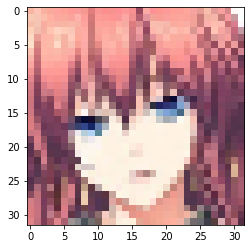

In [11]:
from google.colab.patches import cv2_imshow
plt.imshow(ae_dataset[200])

#Encoder Part

In [12]:
latentDim = 128
inputShape = (hight, hight, 3)
chanDim = 3
depth = 1

In [13]:
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
x = Dense(8192)(x)
x = Dense(2048)(x)
latent = Dense(latentDim)(x)

In [14]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                           

#Decoder part

In [15]:
latentInputs = Input(shape=(latentDim,))
x = Dense(2048)(latentInputs)
x = Dense(8192)(x)
x = Dense(np.prod(volumeSize[1:]))(x)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [16]:
x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [17]:
x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [18]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 2048)              264192    
                                                                 
 dense_4 (Dense)             (None, 8192)              16785408  
                                                                 
 dense_5 (Dense)             (None, 512)               4194816   
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 128)        147584    
 nspose)                                                         
                                                           

In [19]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 128)               21342432  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         21490275  
                                                                 
Total params: 42,832,707
Trainable params: 42,831,747
Non-trainable params: 960
_________________________________________________________________


#Spliting datasets

In [20]:
EPOCHS = 50
Batch_Size = 32

In [21]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [22]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

In [23]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [24]:
def show_prediction(epoch, logs):
    if epoch % 10 == 1:
        decoded_imgs = autoencoder.predict(ae_dataset[:4])
        n = 10  # number of digits to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(ae_dataset[i].reshape(hight, hight))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(hight, hight))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()


In [25]:
checkpoint_path = "/content/drive/MyDrive/AutoEncoders/best_model.h5"

In [26]:
mc = ModelCheckpoint('checkpoints/weights{epoch:03d}.h5', save_weights_only=True, period=10)
early_stop = EarlyStopping(monitor='loss', patience=4)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

In [27]:
history = autoencoder.fit(
	x= ae_dataset,
	y= ae_dataset, 
	epochs=EPOCHS,
	batch_size=Batch_Size,
	callbacks=[mc, early_stop, checkpoint])

Epoch 1/50
1987/1987 [==============================] - ETA: 0s - loss: 0.0372
Epoch 1: loss improved from inf to 0.03721, saving model to /content/drive/MyDrive/AutoEncoders/best_model.h5
1987/1987 [==============================] - 50s 20ms/step - loss: 0.0372
Epoch 2/50
1985/1987 [============================>.] - ETA: 0s - loss: 0.0329
Epoch 2: loss improved from 0.03721 to 0.03294, saving model to /content/drive/MyDrive/AutoEncoders/best_model.h5
1987/1987 [==============================] - 35s 18ms/step - loss: 0.0329
Epoch 3/50
1986/1987 [============================>.] - ETA: 0s - loss: 0.0325
Epoch 3: loss improved from 0.03294 to 0.03249, saving model to /content/drive/MyDrive/AutoEncoders/best_model.h5
1987/1987 [==============================] - 35s 18ms/step - loss: 0.0325
Epoch 4/50
1987/1987 [==============================] - ETA: 0s - loss: 0.0322
Epoch 4: loss improved from 0.03249 to 0.03217, saving model to /content/drive/MyDrive/AutoEncoders/best_model.h5
1987/1987 

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import argparse
import cv2

KeyError: ignored

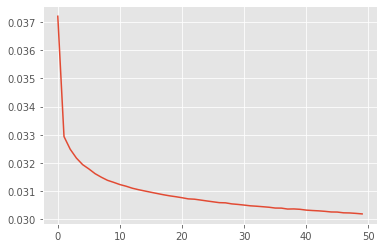

In [44]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [30]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(ae_dataset[:25])
outputs = None

[INFO] making predictions...
1/1 [==============================] - 1s 547ms/step


In [36]:
decoded.shape

(25, 32, 32, 3)

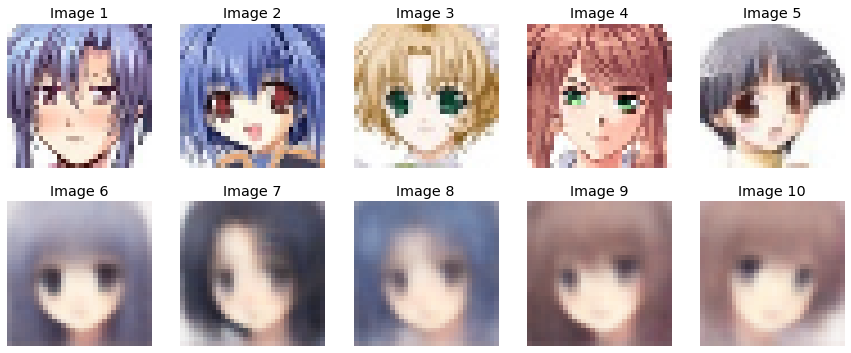

In [46]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      if i == 0:
        ax[i, j].imshow(ae_dataset[i*5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {i*5 + j + 1}')
      else:
        ax[i, j].imshow(decoded[i*5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {i*5 + j + 1}')

plt.show()